## Construção do Modelo Preditivo

Após realizar uma análise exploratória detalhada dos dados, identificamos padrões e insights que orientarão a construção do modelo preditivo. 

Nesta etapa, focaremos em:
1. Preparar os dados para modelagem, garantindo que todas as variáveis estejam no formato adequado.
2. Escolher um algoritmo de aprendizado de máquina adequado para a previsão, considerando a natureza dos dados.
3. Avaliar o desempenho do modelo utilizando métricas apropriadas, como RMSE, MAE ou R².

**USANDO PYTHON 3.13 COMO CONSTA NO DOCKERFILE**

### Importando bibliotecas

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

### Lendo os dados

In [42]:
dataset = pd.read_csv("../data/model_inputs/ml_inputs.csv", sep=";", decimal=",")

In [43]:
dataset.columns

Index(['QT_VENDA_BRUTO', 'VL_PRECO', 'QT_DEVOLUCAO', 'VL_RECEITA_BRUTA'], dtype='object')

In [44]:
target = "VL_RECEITA_BRUTA"
X = dataset.drop(columns=target)
y = dataset[target]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [46]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

joblib.dump(model, "../models/model.pkl")

KeyboardInterrupt: 

### Testando cross-validation para avaliar a performance do modelo em diferentes folds com o objetivo de verificar a consistência nas predições

In [29]:
# Initialize the model
model = RandomForestRegressor(random_state=42)

# Perform cross-validation
cv_results = cross_validate(
    model,
    X_train,  # Use raw data, no need for scaling
    y_train,
    cv=5,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
)

# Print the cross-validation results
print(f"Cross-Validation R2 Scores: {cv_results['test_r2']}")
print(f"Cross-Validation MSE Scores: {-cv_results['test_neg_mean_squared_error']}")
print(f"Cross-Validation MAE Scores: {-cv_results['test_neg_mean_absolute_error']}")

# Compute mean scores
print(f"Mean R2: {np.mean(cv_results['test_r2'])}")
print(f"Mean MSE: {np.mean(-cv_results['test_neg_mean_squared_error'])}")
print(f"Mean MAE: {np.mean(-cv_results['test_neg_mean_absolute_error'])}")

Cross-Validation R2 Scores: [0.99744366 0.99745402 0.98487526 0.96458109 0.98888844]
Cross-Validation MSE Scores: [1.83046293e+10 2.17436200e+10 1.14176185e+11 3.42099879e+11
 8.76678556e+10]
Cross-Validation MAE Scores: [11914.45037816 11388.99076744 15136.45140537 15159.9360031
 14291.96267761]
Mean R2: 0.9866484944236262
Mean MSE: 116798433678.94556
Mean MAE: 13578.35824633465


### Verifica-se previsões bem alinhadas, o que pode indicar overfitting

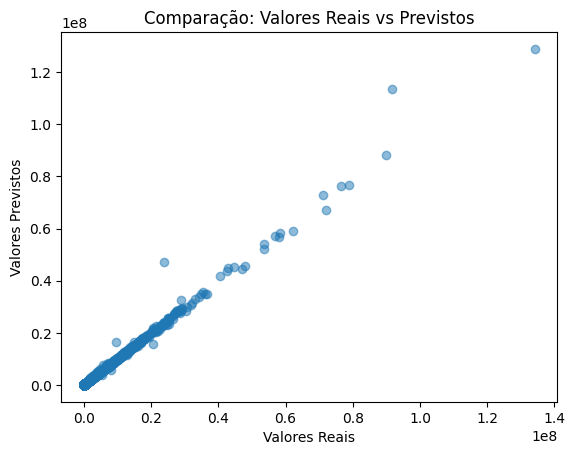

In [30]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title("Comparação: Valores Reais vs Previstos")
plt.show()

### Uma alta correlação entre as variáveis e o target pode indicar/explicar as métricas atingidas anteriormente.
- Verificou-se as importâncias de features e se não ouve data leakeage durante o processo
- Desde o começo da análise exploratória foi possível averiguar a grande correlação entre estas variáveis, o que se destacou também ao treinar o modelo inicial.

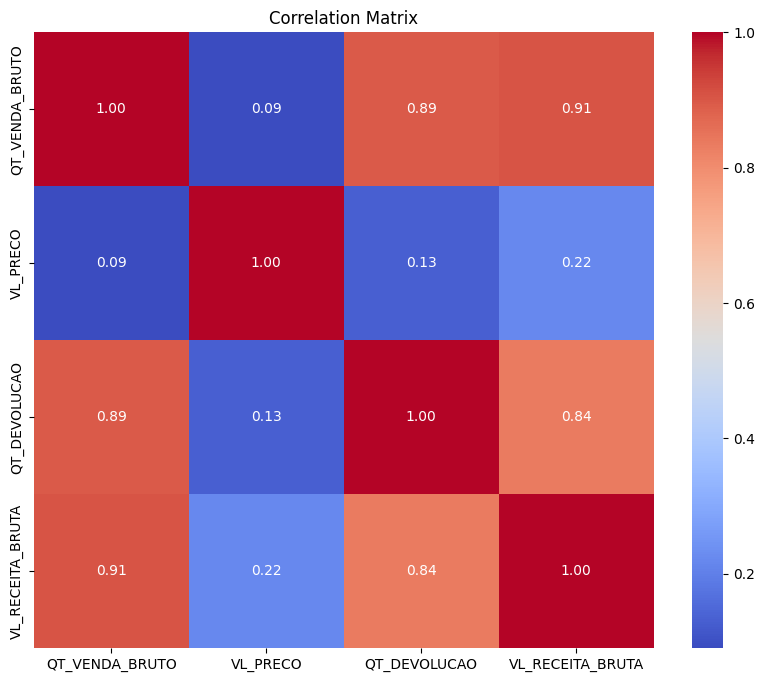

In [31]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = dataset.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Agora, separaremos os produtos principais e treinar um modelo para eles, assim diminuindo o escopo e avaliando os resultados de uma abordagem mais direcionada

In [32]:
dataset.QT_VENDA_BRUTO

0         11934.0
1           540.0
2         54012.0
3           438.0
4          2760.0
           ...   
173918     4266.0
173919     7224.0
173920      360.0
173921      384.0
173922      888.0
Name: QT_VENDA_BRUTO, Length: 173923, dtype: float64

In [33]:
processed_data = pd.read_csv("../data/processed/dataset.csv", sep=";", decimal=",")

In [34]:
sales_per_product = processed_data.groupby("COD_MATERIAL")["QT_VENDA_BRUTO"].sum()

In [35]:
most_sold_products = sales_per_product.sort_values(ascending=False).head(5)
most_sold_products

COD_MATERIAL
177396    5.177174e+07
69198     3.468620e+07
427350    3.308824e+07
441876    2.961724e+07
152982    2.615941e+07
Name: QT_VENDA_BRUTO, dtype: float64

In [36]:
top_products = processed_data[
    processed_data["COD_MATERIAL"].isin(most_sold_products.index)
]

In [37]:
dataset.columns

Index(['QT_VENDA_BRUTO', 'VL_PRECO', 'QT_DEVOLUCAO', 'VL_RECEITA_BRUTA'], dtype='object')

In [38]:
top_products[dataset.columns]

,QT_VENDA_BRUTO,VL_PRECO,QT_DEVOLUCAO,VL_RECEITA_BRUTA
447,123018.0000,1071.90,3373.713503,17126833.26
472,82896.0000,1073.40,1722.000000,11563555.80
575,109708.7766,634.02,2693.668476,7152097.26
642,43734.0000,863.40,1530.000000,4563006.00
909,57468.0000,563.40,1860.000000,3141918.60
...,...,...,...,...
172809,46848.0000,803.40,870.000000,4423902.60
173009,126312.0000,683.40,1602.000000,9443476.20
173297,374520.0000,485.34,8122.569085,15531709.62
173316,140592.0000,563.40,2526.000000,7705888.20


In [39]:
for product in most_sold_products.index:
    product_data = top_products[top_products["COD_MATERIAL"] == product]
    product_data = product_data[dataset.columns]
    X_product = product_data.drop(columns="QT_VENDA_BRUTO")
    y_product = product_data["QT_VENDA_BRUTO"]

    X_train, X_test, y_train, y_test = train_test_split(
        X_product, y_product, test_size=0.2, random_state=42
    )

    rf_model_product = RandomForestRegressor(random_state=42)
    rf_model_product.fit(X_train, y_train)

    y_pred = rf_model_product.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Product: {product}")
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"R2: {r2}")

Product: 177396
MSE: 3262092488.097571
MAE: 19486.181860465116
R2: 0.8880203024772659
Product: 69198
MSE: 2045359575.250005
MAE: 15618.413773953494
R2: 0.9828725829714082
Product: 427350
MSE: 958833522.611396
MAE: 12149.69984302326
R2: 0.9169641244896795
Product: 441876
MSE: 23626564650.6228
MAE: 43883.72608695652
R2: 0.8752906076015163
Product: 152982
MSE: 415537887.70682794
MAE: 11296.794418604652
R2: 0.9728583834841682


## Desempenho do Modelo por Produto

O desempenho do modelo foi avaliado em diferentes produtos para verificar sua capacidade preditiva em subconjuntos específicos de dados. Abaixo estão os resultados para cada produto:

---

### **Métricas de Desempenho**

| **Produto** | **MSE**             | **MAE**         | **R²**        |
|-------------|---------------------|-----------------|---------------|
| **177396**  | 3.262.092.488,10    | 19.486,18       | 0,8880        |
| **69198**   | 2.045.359.575,25    | 15.618,41       | 0,9829        |
| **427350**  | 958.833.522,61      | 12.149,70       | 0,9170        |
| **441876**  | 23.626.564.650,62   | 43.883,73       | 0,8753        |
| **152982**  | 415.537.887,71      | 11.296,79       | 0,9729        |

---

### **Principais Observações**
1. **Valores de R²:**
   - Os valores de R² indicam um forte poder preditivo para todos os produtos, variando de **0,87** a **0,98**.
   - Isso sugere que o modelo explica uma grande parte da variabilidade na demanda de cada produto.

2. **MSE (Erro Quadrático Médio):**
   - O MSE varia significativamente entre os produtos, refletindo diferenças na variabilidade da demanda.
   - Produtos como **441876**, com MSE mais elevado, podem apresentar flutuações de demanda maiores ou mais imprevisíveis.

3. **MAE (Erro Absoluto Médio):**
   - O MAE fornece uma visão clara do erro médio nas previsões de cada produto.
   - Produtos como **152982** e **427350** apresentam MAE relativamente baixos, indicando previsões mais precisas.

---

### **Conclusão**
O modelo demonstra um desempenho robusto para diferentes produtos, com altos valores de R² e erros consistentes. No entanto, produtos com MSE e MAE mais elevados, como **441876**, podem demandar uma análise mais detalhada ou ajustes específicos no modelo para melhor capturar padrões de demanda únicos.

---


In [40]:
joblib.dump(rf_model_product, "../models/model_product.pkl")

['../models/model_product.pkl']